구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


필요한 라이브러리 호출

In [ ]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F

from torch.optim.lr_scheduler import LRScheduler, ReduceLROnPlateau,CosineAnnealingWarmRestarts
from PIL import Image

import time
import shutil
import fnmatch
import scipy.io as sio
import math


import torchvision.models as models
from torch.autograd import Variable

import json
from multiprocessing import Pool
import itertools

import zipfile

기본 디렉토리 설정

In [ ]:
# 아래 미션 수행 과정에서 디렉토리 경로를 간단하게 만들기 위함
base_dir = '/gdrive/MyDrive/DCC_DAITA'
os.chdir(base_dir)

## **MISSION 1-1**

training_image와 validation_image 폴더 내 파일명 불러와서 저장 및 개수 확인

In [ ]:
training_image_filename = os.listdir('training_image')
validation_image_filename = os.listdir('validation_image')
print(f"Training image 개수: {len(training_image_filename)}, validation image 개수: {len(validation_image_filename)}")

Training image 개수: 4070, validation image 개수: 951


training_image 폴더 내 파일명을 '_'을 기준으로 나눠서 'W/T', '이미지ID', '시대별', '스타일별', '성별'에 맞게 데이터프레임으로 저장

In [ ]:
# 파일명을 확장자 '.jpg'를 제외하고 '_' 기준으로 분리
training_image = [filename[:-4].split('_') for filename in training_image_filename]
# 'W/T', '이미지ID', '시대별', '스타일별', '성별'을 컬럼으로 하는 데이터 프레임 생성
training_image = pd.DataFrame(training_image, columns=['W/T', '이미지ID', '시대별', '스타일별', '성별'])

training_image를 '성별', '스타일별'을 기준으로 '이미지ID' 개수 세기

In [ ]:
# '성별', '스타일별'를 기준으로 해서 '이미지ID' 개수 세기
training_image = pd.DataFrame(training_image.groupby(['성별', '스타일별'])['이미지ID'].count())
# 인덱스를 리셋하고 컬럼으로 '성별', '스타일', '이미지수' 지정
training_image.reset_index(inplace=True)
training_image.columns = ['성별', '스타일', '이미지수']
# csv 파일로 저장
training_image.to_csv('Mission1_1_training_image.csv', index=False)
# 데이터 프레임 확인
training_image

,성별,스타일,이미지수
0,M,bold,268
1,M,hiphop,274
2,M,hippie,260
3,M,ivy,237
4,M,metrosexual,278
5,M,mods,269
6,M,normcore,364
7,M,sportivecasual,298
8,W,athleisure,67
9,W,bodyconscious,95


validation_image 폴더 내 파일명을 '_'을 기준으로 나눠서 'W/T', '이미지ID', '시대별', '스타일별', '성별'에 맞게 데이터프레임으로 저장

In [ ]:
# 파일명을 확장자 '.jpg'를 제외하고 '_' 기준으로 분리
validation_image = [filename[:-4].split("_") for filename in validation_image_filename]
# 'W/T', '이미지ID', '시대별', '스타일별', '성별'을 컬럼으로 하는 데이터 프레임 생성
validation_image = pd.DataFrame(validation_image, columns=['W/T', '이미지ID', '시대별', '스타일별', '성별'])

validation_image를 '성별', '스타일별'로 데이터 프레임을 정리하고 '이미지ID' 기준으로 개수 세기

In [ ]:
# '성별', '스타일별'를 기준으로 해서 '이미지ID' 개수 세기
validation_image = pd.DataFrame(validation_image.groupby(['성별', '스타일별'])['이미지ID'].count())
# 인덱스를 리셋하고 컬럼으로 '성별', '스타일', '이미지수' 지정
validation_image.reset_index(inplace=True)
validation_image.columns = ['성별', '스타일', '이미지수']
# csv 파일로 저장
validation_image.to_csv('Mission1_1_validation_image.csv', index=False)
# 데이터 프레임 확인
validation_image

,성별,스타일,이미지수
0,M,bold,57
1,M,hiphop,66
2,M,hippie,82
3,M,ivy,79
4,M,metrosexual,58
5,M,mods,80
6,M,normcore,51
7,M,sportivecasual,52
8,W,athleisure,14
9,W,bodyconscious,23


# **MISSION 1-2**

재현 가능성을 위해 시드 고정

In [ ]:
torch.manual_seed(42)

1-1에서 '스타일_성별'을 리스트 추출하여 클래스 가져오기

In [ ]:
# 1-1 결과에서 '스타일_성별'을 리스트로 추출
training_image_df = pd.read_csv('Mission1_1_training_image.csv')
training_image_df['스타일_성별'] = training_image_df['스타일'] + "_" + training_image_df["성별"]
style_sex = training_image_df['스타일_성별'].tolist()

train_dir와 validation_dir 설정



In [ ]:
# image cropping을 통해 배경 제거된 이미지 저장한 후
# transforms.resize(300), transforms.CenterCrop((224, 224)) 적용한 결과를 저장하여 하위 폴더에 클래스별로 분류 완료
# training_image, validation_image 모두 적용, 다음 폴더 경로에서 사용
train_dir = 'crop_training_image_transformed'
validation_dir = 'crop_validation_image_transformed'

fig_and_result_dir와 model_dir 설정

In [ ]:
# loss, accuracy 결과 값과 그래프를 저장할 폴더 경로
fig_and_result_dir = 'fig_and_result'
if not os.path.exists(fig_and_result_dir):
        os.mkdir(fig_and_result_dir)
# 학습한 모델 가중치 저장할 폴더 경로
model_dir = 'model_weights'
if not os.path.exists(model_dir):
  os.mkdir(model_dir)

device 설정

In [ ]:
# cuda로 device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

dataset에 torchvision.transform 적용하여 ImageFolder로 dataset 가져오기

In [ ]:
# 이미 transforms.resize(300), transforms.CenterCrop((224, 224)) 적용한 결과 이미지를 불러와서 사용
# 따라서 transforms.ToTensor(), transforms.Normalize()만 수행
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])
# ImageFolder를 사용해서 dataset 설정, 따라서 미리 클래스별로 하위 폴더에 저장 완료
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
validation_dataset = datasets.ImageFolder(validation_dir, transform=transform)

hyperparameter 설정 for dataloader

In [ ]:
n_batch = 128
num_workers = 2

dataloader 생성

In [ ]:
# dataset을 가지고 dataloader 생성
train_loader = DataLoader(train_dataset, batch_size=n_batch, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(validation_dataset, batch_size=n_batch, shuffle=False, num_workers=num_workers)

BasicBlock Class 정의하기

In [ ]:
# ResNet18 모델 구조를 보고 작성
# ResNet18을 구성하는 BasicBlock 클래스 정의
class BasicBlock(nn.Module):

  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out


ResNet Class 정의하기

In [ ]:
# ResNet18 모델 구조를 보고 작성
# ResNet 클래스 정의
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
    super(ResNet, self).__init__()
    self.in_channels = 64

    self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_classes)


    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    # 가중치 초기화
    if zero_init_residual:
      for m in self.modules():
        if isinstance(m, BasicBlock):
          nn.init.constant_(m.bn2.weight, 0)
  # BasicBlock을 가지고 layer 생성
  def _make_layer(self, block, out_channels, blocks, stride=1):

    downsample = None
    if stride != 1 or self.in_channels != out_channels:
      downsample = nn.Sequential(
        nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels))

    layers = []

    layers.append(block(self.in_channels, out_channels, stride, downsample))

    self.in_channels = out_channels
    for _ in range(1, blocks):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

Resnet18 생성을 위한 함수 선언

In [ ]:
def resnet18(num_classes, zero_init_residual):
  return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, zero_init_residual)

validation_image를 가지고 모델의 loss, accuracy를 도출

In [ ]:
def compute_val(model, loader, device, criterion):
    # 모델을 평가 모드로 전환
    model.eval()
    # loss, correct 초기화
    eval_loss = 0.0
    correct = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
             # loss 저장
            eval_loss += criterion(outputs, labels).item()
            # predictions 저장
            predictions = outputs.argmax(dim=1)
            # 예측이 맞는지 확인하고 맞다면 correct에 개수 저장
            correct += predictions.eq(labels.view_as(predictions)).sum().item()

    # 평균 loss 값 저장
    avg_eval_loss = eval_loss / len(loader)
    # 정확도 계산
    accuracy = 100 * correct / len(loader.dataset)
    return avg_eval_loss, accuracy

클래스별 정확도를 확인하기 위해 예측 결과와 라벨 저장

In [ ]:
def load_pred(model, device, loader):
    # 모델을 평가 모드로 전환
    model.eval()
    all_predictions, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            # predictions 저장
            predictions = outputs.argmax(dim=1)
            # predictions를 all_predictions에 계속 저장
            all_predictions.extend(predictions.cpu().numpy())
            # labels를 all_labels에 저장
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels


epoch 수만큼 training하고 training_loss, accuracy 반환하고


compute_val을 호출해서 validation_loss, accuracy 반환

In [ ]:
def train_and_valid(model, device, train_loader, valid_loader, criterion, optimizer, scheduler, model_path, epochs, log_interval=10):
  # losses 딕셔너리 초기화
  losses = {'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            }

  # predictions 딕셔너리 초기화
  predictions = {'val_predictions': [], 'val_labels': []}
  # 시작 시점 확인
  start = time.time()
  # 정해진 epoch 수만큼 반복
  for epoch in range(epochs):
    print(f'Epoch: {epoch+1:0>4}.../ {epochs} \n')
    print(f"lr ={scheduler.optimizer.param_groups[0]['lr']}")
    # 모델을 학습모드로 전환
    model.train()
    # running_loss, running_acc 초기화
    running_loss = 0.0
    running_acc = 0

    for i, (image, label) in enumerate(train_loader):
      image, label = image.to(device), label.to(device)

      optimizer.zero_grad()

      output = model(image)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      # loss 누적
      running_loss += loss.item()
      # 예측값 저장
      label_pred = output.argmax(dim=1)
      # 예측하여 정답을 맞춘 개수를 누적
      running_acc += (label == label_pred).sum().item()
    # 평균 loss 값 계산
    train_loss = running_loss / len(train_loader)
    # 평균 accuracy 값 계산
    train_acc = 100.0 * running_acc / len(train_loader.dataset)
    # losses 딕서너리에 저장
    losses['train_loss'].append(train_loss)
    losses['train_acc'].append(train_acc)

    # validation image로 평가하여 평균 loss 값과 accuracy 값을 반환
    val_loss, val_acc = compute_val(model, valid_loader, device, criterion)
    # losses 딕서너리에 저장
    losses['val_loss'].append(val_loss)
    losses['val_acc'].append(val_acc)
    # 매 epoch train_loss, train_acc, val_loss, val_acc 출력
    print(f"train_loss: {(train_loss):.4f},\t train_acc: {(train_acc):.4f} % ")
    print('val_loss: {:.4f},'.format(val_loss), end='\t')
    print('val_acc: {:.4f} % '.format(val_acc), end='\n')
    print('---------------------------------------\t')

    scheduler.step()

  # 모든 epoch 끝나서 학습 완료된 모델로 예측 결과와 라벨을 predictions 딕셔너리에 저장
  predictions['val_predictions'], predictions['val_labels'] = load_pred(model, device, valid_loader)
  # 끝나는 시점을 기록하여 총 걸린 시간을 계산
  end = time.time()

  # 학습 시간과 best score를 출력(best score은 val_acc의 최댓값)
  print(f"training time: {(end-start)/60:.3f} minutes, best score: {max(losses['val_acc']):.4f}%")
  return losses, predictions

resnet18 함수를 호출하여 모델 선언

In [ ]:
model = resnet18(num_classes=len(style_sex), zero_init_residual=True).to(device)

클래스별 데이터 분포에 맞춰 가중치 설정해서 criterion 선언

In [ ]:
# 클래스 별 이미지 수를 리스트로 저장
num_ins = list(training_image_df['이미지수'])
# 클래스 별 이미지 수를 이용하여 가중치 설정
weights = [1 - (x / sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
# 손실 함수에 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

hyperparmeter 설정 for optimizer, lr_scheduler

In [ ]:
lr = 0.01
weight_decay = 0.1
eta_min = 0.0001
T_0 = 22
n_epochs = 22

optimzer 및 lr_scheduler 선언

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=1, eta_min=eta_min, last_epoch=-1)

training 진행 및 결과 저장

Epoch: 0001.../ 22 

lr =0.01
train_loss: 3.2756,	 train_acc: 8.2064 % 
val_loss: 3.7118,	val_acc: 5.3628 % 
---------------------------------------	
Epoch: 0002.../ 22 

lr =0.009949616137310617
train_loss: 3.1261,	 train_acc: 8.8206 % 
val_loss: 3.1274,	val_acc: 8.4122 % 
---------------------------------------	
Epoch: 0003.../ 22 

lr =0.009799490219391763
train_loss: 3.0759,	 train_acc: 10.4914 % 
val_loss: 6.0210,	val_acc: 3.1546 % 
---------------------------------------	
Epoch: 0004.../ 22 

lr =0.009552678377004867
train_loss: 3.0274,	 train_acc: 11.1548 % 
val_loss: 3.3569,	val_acc: 6.5195 % 
---------------------------------------	
Epoch: 0005.../ 22 

lr =0.009214204987514346
train_loss: 2.9980,	 train_acc: 12.0639 % 
val_loss: 3.2807,	val_acc: 6.2040 % 
---------------------------------------	
Epoch: 0006.../ 22 

lr =0.008790960393053578
train_loss: 2.9649,	 train_acc: 12.5553 % 
val_loss: 3.6832,	val_acc: 3.6803 % 
---------------------------------------	
Epoch: 0007.../ 

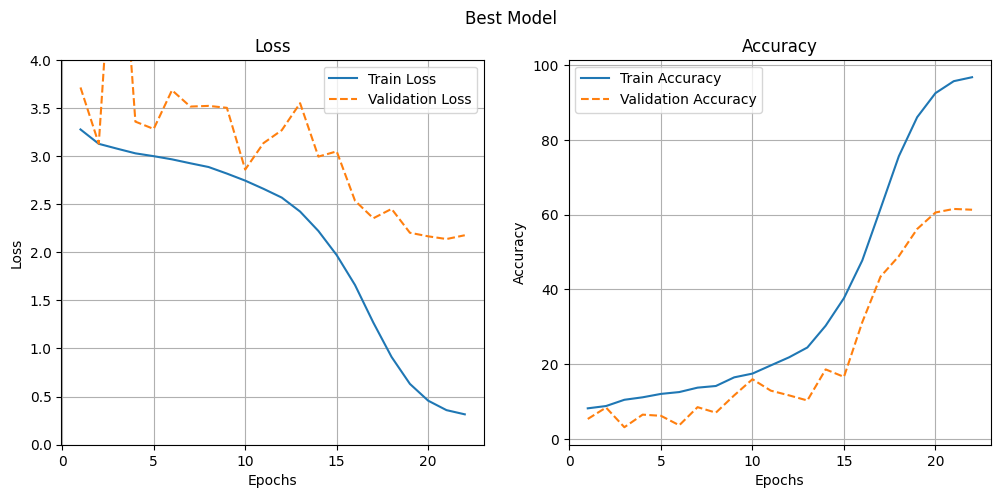

In [ ]:
# train_and_valid 함수를 호출하여 학습하고 losses, predictions 딕셔너리 반환
losses, predictions = train_and_valid(model, device, train_loader, valid_loader, criterion, optimizer, scheduler, model_dir, n_epochs, log_interval=10)
# 모델의 가중치 저장
torch.save(model.state_dict(), model_dir+'/best_model.pt')
# train_loss, train_acc, val_loss, val_acc 그래프로 그려서 저장
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
x = np.arange(len(losses['train_loss']))+1
# loss 그래프
ax[0].plot(x, losses['train_loss'], label="Train Loss")
ax[0].plot(x, losses['val_loss'], "--", label="Validation Loss")
ax[0].set_ylim(0, 4)

ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True)

# acc 그래프
ax[1].plot(x, losses['train_acc'], label="Train Accuracy")
ax[1].plot(x, losses['val_acc'], "--", label="Validation Accuracy")

ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True)

fig.suptitle('Best Model')

plt.savefig(fig_and_result_dir + '/loss_accuracy_plot.png')




loss와 accuracy 확인

In [ ]:
# losses 딕셔너리로 데이터 프레임 생성
losses_df = pd.DataFrame.from_dict(losses, orient='index', dtype=float)
# 컬럼명을 epoch 수로 변경
losses_df.columns = ['Epoch_'+str(i+1) for i in range(len(losses['train_loss']))]
# 데이터 프레임을 저장
losses_df.to_csv(fig_and_result_dir + '/MISSION1_2_model_result_losses.csv',  header=True, index=True)
losses_df

,Epoch_1,Epoch_2,Epoch_3,Epoch_4,Epoch_5,Epoch_6,Epoch_7,Epoch_8,Epoch_9,Epoch_10,...,Epoch_13,Epoch_14,Epoch_15,Epoch_16,Epoch_17,Epoch_18,Epoch_19,Epoch_20,Epoch_21,Epoch_22
train_loss,3.275582,3.126093,3.075888,3.027427,2.997973,2.964909,2.924167,2.885171,2.817079,2.743929,...,2.422572,2.220795,1.970073,1.659575,1.269556,0.911472,0.632288,0.457384,0.359334,0.315695
train_acc,8.206388,8.820639,10.491400,11.154791,12.063882,12.555283,13.734644,14.176904,16.486486,17.493857,...,24.471744,30.294840,37.665848,47.739558,61.621622,75.626536,86.044226,92.481572,95.675676,96.732187
val_loss,3.711778,3.127387,6.020975,3.356869,3.280730,3.683162,3.513271,3.520263,3.500265,2.858974,...,3.548406,2.993422,3.047738,2.535226,2.352752,2.450132,2.202341,2.165121,2.137055,2.176289
val_acc,5.362776,8.412198,3.154574,6.519453,6.203996,3.680336,8.517350,7.045216,11.671924,15.983176,...,10.304942,18.611987,16.614090,31.230284,43.427971,48.895899,56.151420,60.567823,61.514196,61.303891


predictions 확인

In [ ]:
# predictions 딕셔너리로 데이터 프레임 생성
predictions_df = pd.DataFrame.from_dict(predictions, orient='index', dtype=int)
# 데이터 프레임을 저장
predictions_df.to_csv(fig_and_result_dir + '/MISSION1_2_model_result_predictions.csv', index=True)
predictions_df

,0,1,2,3,4,5,6,7,8,9,...,941,942,943,944,945,946,947,948,949,950
val_predictions,30,0,0,18,7,0,0,0,0,23,...,30,18,30,22,30,30,30,30,30,30
val_labels,0,0,0,0,0,0,0,0,0,0,...,30,30,30,30,30,30,30,30,30,30


predictions를 가지고 클래스별 정확도 계산

In [ ]:
# 리스트 초기화
precision = []
recall = []
f1_scores = []
accuracy = []

for idx, class_name in enumerate(validation_dataset.class_to_idx):
    tp = 0.0  # True Positives
    fp = 0.0  # False Positives
    fn = 0.0  # False Negatives
    correct = 0.0  # 정확도 계산
    cnt = 0

    for i, row in predictions_df.items():
        val_label = row['val_labels']  # 실제 라벨
        val_prediction = row['val_predictions']  # 예측 값

        if val_label == idx and val_prediction == idx:  # True Positive
            tp += 1.0
            correct += 1.0
            cnt+=1
        elif val_prediction == idx and val_label != idx:  # False Positive
            fp += 1.0
        elif val_label == idx and val_prediction != idx:  # False Negative
            fn += 1.0
            cnt+=1

    # accuracy 계산 (TP / 클래스당 데이터 수)
    accuracy_val = correct / cnt if cnt > 0 else 0.0
    accuracy.append(accuracy_val)

    # Precision, Recall, F1-score 계산
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0.0

    precision.append(precision_val)
    recall.append(recall_val)
    f1_scores.append(f1_score_val)

# DataFrame으로 정리
accuracy_df = pd.DataFrame({
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_scores
}, index=list(validation_dataset.class_to_idx.keys()))

# 데이터 프레임을 저장
accuracy_df.to_csv(fig_and_result_dir + '/MISSION1_2_model_result_class_acc.csv', header=True, index=True)
accuracy_df

,accuracy,precision,recall,f1_score
athleisure_W,0.642857,0.750000,0.642857,0.692308
bodyconscious_W,0.739130,0.809524,0.739130,0.772727
bold_M,0.543860,0.596154,0.543860,0.568807
cityglam_W,0.500000,0.818182,0.500000,0.620690
classic_W,0.681818,0.833333,0.681818,0.750000
disco_W,0.300000,0.750000,0.300000,0.428571
ecology_W,0.588235,0.666667,0.588235,0.625000
feminine_W,0.659091,0.743590,0.659091,0.698795
genderless_W,0.833333,0.434783,0.833333,0.571429
grunge_W,0.600000,0.857143,0.600000,0.705882
